In [1]:
import pandas as pd
import data_util
from tqdm import tqdm_notebook as tqdm
from data_generator import DataGenerator
from state_util import StateUtil
from tec_an import TecAn
from data_agent import *
import numpy as np
from data_util import *
import tensorflow as tf
from sklearn_model_hyper import *
import pandas as pd
from stock_agent import *
from backtest import *
from joblib import dump, load
from datetime import datetime, timedelta
from tec_an import *
from bitstamp import *
from process_live_trade import *
from model_winner_select import *
from eval_model import *
from cache_providers import *

base_dir = "data/"

In [2]:
currency = "btcusd"

full_data = base_dir + "backtest/"
full_data = base_dir + "4jul21/"
#full_data = base_dir + "btcusd/"
data_gen = DataGenerator(random = False, base_dir = full_data)
data_gen.rewind()
data_count = (data_gen.steps - 100)
#data_count = 200000
raw = data_gen.next()

minute = 30

hot_load = True

In [3]:
path = "model/"
files = os.listdir(path)
models = []
for file in files:
    models.append(f"{path}{file}")

models = ['model/rand']
#models = ['model/quadra']
    
val_start = int(raw['timestamp'])

In [4]:
winner = get_best_model(
    minutes_list=[minute],
    result_paths=models,
    currency_list=[currency],
    timestamp = val_start,
    winner_path = None
)

model/rand - 200
Pre selected: 109


  2%|▏         | 2/109 [00:15<13:46,  7.72s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]


  3%|▎         | 3/109 [00:29<18:39, 10.56s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]


 16%|█▌        | 17/109 [00:44<03:12,  2.09s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]


 17%|█▋        | 18/109 [00:53<03:59,  2.63s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]


 17%|█▋        | 19/109 [01:02<04:52,  3.25s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]


 26%|██▌       | 28/109 [01:10<02:33,  1.90s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]


 28%|██▊       | 30/109 [01:18<02:55,  2.22s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]


 30%|███       | 33/109 [01:26<02:58,  2.34s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]


 35%|███▍      | 38/109 [01:40<02:59,  2.53s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]


 38%|███▊      | 41/109 [01:48<02:55,  2.58s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]


 42%|████▏     | 46/109 [01:56<02:19,  2.22s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]


 47%|████▋     | 51/109 [02:04<01:55,  1.99s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]


100%|██████████| 109/109 [02:12<00:00,  1.21s/it]

[1625401800, 1625403600, 1625405400, 1625407200, 1625409000, 1625410800, 1625412600, 1625414400, 1625416200, 1625418000]
[1625401800 1625403600 1625405400 1625407200 1625409000 1625410800
 1625412600 1625414400 1625416200 1625418000]
Selected: 13
Pipeline(steps=[('normalizer', Normalizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_features=0.1, random_state=42))])
btcusd -> 100.33378527523628 | 2 - 0
{'recall': 0.42833052276559863, 'precision': 0.436426116838488, 'f1': 0.4323404255319149, 'accuracy': 0.5374479889042996}

Pipeline(steps=[('normalizer', Normalizer()),
                ('pipeline',
                 Pipeline(steps=[('s',
                                  RFE(estimator=ExtraTreesClassifier(max_features=0.3,
                                                                     random_state=42),
                                      step=0.750000000000000

In [5]:
result = winner
if (winner == None):
    result = results[-1]
model = result['model']
windows = result['window']
minutes = result['minutes']
step = result['step']
profit = result['profit']
print(f"Minutes={minutes} Window={windows} Step={step} | {profit}")
print(f"{model}")


Minutes=30 Window=40 Step=1 | 103.5047554015294
RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=0.1,
                       random_state=42)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
def get_charts(stock_data):
    fig = plt.figure()
    ax = plt.axes()
    x = stock_data
    plt.plot(x, linewidth=1)
    #plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
    plt.show()


In [7]:

on_raw_data = lambda raw: print(raw)

data_gen.rewind()

first = data_gen.next()

In [8]:
agent_reference, back_reference, stock_reference = get_agent(minutes = minutes,
                                win = windows,
                                step = step,
                                currency = currency,
                                hot_load = hot_load,
                                model = model,
                                timestamp = int(first['timestamp']),
                                simulate_on_price = True,
                                verbose = False)
prices = []
agent_reference.on_closed_price = lambda price: prices.append(price)
#agent.ohlc['open'].plot()

In [9]:
data_gen.rewind()


reference_list = []
#data_count
for i in tqdm(range(data_count)):
    raw = data_gen.next()
    price = raw[PRICE_KEY]
    amount = raw[AMOUNT_KEY]
    timestamp = raw[TIMESTAMP_KEY]
    timestamp_pd = pd.to_datetime(timestamp, unit='s')
    reference_list.append([timestamp_pd, price])


  0%|          | 0/301794 [00:00<?, ?it/s]

In [10]:
DATE = 'Date'
df = pd.DataFrame(agent_reference.list, columns = [DATE, CLOSE])
df = df.set_index(pd.DatetimeIndex(df[DATE]))

In [11]:
time = df[CLOSE].resample(agent_reference.resample)
ohlc = time.ohlc()
print("All data reference")
#ohlc.plot()
#ohlc

All data reference


In [12]:
cache = CacheProvider([currency],  verbose = True)


In [13]:

online = cache.get_provider(minutes, windows, int(first['timestamp']), int(raw['timestamp']))

eval_model(
    model = model, 
    currency = currency, 
    step = step,
    verbose = False, 
    provider = online,
    hot_load_total = 100,
    cache = CacheProvider(currency_list = [currency], verbose=False)
    )

2021-08-21 01:08:02.466617 CacheProvider: Added: 30-40
[1625437800, 1625439600, 1625441400, 1625443200, 1625445000, 1625446800, 1625448600, 1625450400, 1625452200, 1625454000]
[1625437800 1625439600 1625441400 1625443200 1625445000 1625446800
 1625448600 1625450400 1625452200 1625454000]


(<stock_agent.BackTest at 0x7fbac368be20>,
 {'recall': 1.0,
  'precision': 0.23529411764705882,
  'f1': 0.38095238095238093,
  'accuracy': 0.4090909090909091,
  'roc_auc': 0.6388888888888888})

In [14]:
reference_list[0]

[Timestamp('2021-07-04 22:49:41'), 35330.0]

In [15]:
agent_raw, back_raw, stock_raw = get_agent(minutes = minutes,
                                win = windows,
                                step = step,
                                currency = currency,
                                hot_load = hot_load,
                                model = model,
                                verbose = True,
                                timestamp = int(first['timestamp']),
                                simulate_on_price = True)
prices = []

###### Past report(201): 2021-06-30 18:00:00(1625076000) - 2021-07-04 22:00:00(1625436000) ######
2.24684% -> 102.24683675801671
Positive: 31 Negative: 8
###### - ######


In [16]:
agent_raw.history

[]

In [17]:
data_gen.rewind()
agent_raw.save_history = True
stock_raw.verbose = True
#data_count
for i in range(data_count):
    raw = data_gen.next()
    agent_raw.on_new_raw_data(raw)

2021-08-21 01:08:29.126856 ModelAgent(35330.0): 2021-07-04 22:49:41(1625438981) UP
2021-08-21 01:08:29.127014 BackTest: Bought: 35330.0
2021-08-21 01:08:30.594315 ModelAgent(35340.23): 2021-07-04 23:00:04(1625439604) DOWN
2021-08-21 01:08:30.594493 BackTest: SOLD >>>> Result: PROFIT 0.029 total: 100.02895556184546
2021-08-21 01:08:34.890156 ModelAgent(35415.34): 2021-07-04 23:30:08(1625441408) DOWN
2021-08-21 01:08:38.723582 ModelAgent(35247.7): 2021-07-05 00:00:17(1625443217) DOWN
2021-08-21 01:08:43.157503 ModelAgent(34922.82): 2021-07-05 00:30:08(1625445008) UP
2021-08-21 01:08:43.157732 BackTest: Bought: 34922.82
2021-08-21 01:08:47.084648 ModelAgent(34898.82): 2021-07-05 01:00:40(1625446840) DOWN
2021-08-21 01:08:47.084904 BackTest: SOLD >>>> Result: LOSS -0.0687 total: 99.96023258930202
2021-08-21 01:08:50.878619 ModelAgent(34639.91): 2021-07-05 01:30:15(1625448615) DOWN
2021-08-21 01:08:55.227570 ModelAgent(34560.8): 2021-07-05 02:00:08(1625450408) DOWN
2021-08-21 01:08:59.38531

In [18]:
val_start = int(first['timestamp'])
val_end = int(raw['timestamp'])

start_string = pd.to_datetime(val_start, unit='s')
end_string = pd.to_datetime(val_end, unit='s')

print(f"{start_string}({val_start}) -> {end_string}({val_end})")

2021-07-04 22:49:41(1625438981) -> 2021-07-05 08:50:02(1625475002)


In [19]:
back_raw.on_down(back_raw.buy_price, back_raw.buy_price)
back_raw.report()

2021-08-21 01:09:51.332323 BackTest: SOLD >>>> Result: LOSS 0.0 total: 99.96023258930202
-0.03977% -> 99.96023258930202
Positive: 1 Negative: 2


<AxesSubplot:xlabel='Date'>

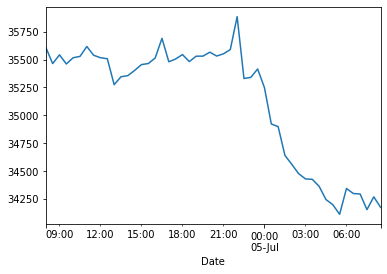

In [20]:
agent_raw.ohlc[-50:]["open"].plot()
#agent.ohlc[1:]

In [23]:
x_list, price_list, time_list = online.load_val_data(currency)

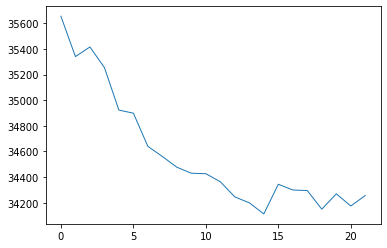

22


In [24]:
get_charts(price_list)
print(len(price_list))

In [30]:
agent_array, back_array, stock_array = get_agent(minutes = minutes,
                                win = windows,
                                step = step,
                                currency = currency,
                                hot_load = hot_load,
                                model = model,
                                timestamp = int(first['timestamp']),
                                simulate_on_price = True,
                                verbose = False)

In [31]:
agent_array.save_history = True
stock_array.verbose = True
for idx in range(len(price_list)):
    price = price_list[idx]
    time = time_list[idx]
    order = [[f"{price}", f"{price}"]]
    amount = 0.0
    agent_array.process_data(price, amount, time, order, order)

2021-08-21 01:14:23.965120 ModelAgent(35655.0): 2021-07-04 22:30:00(1625437800) DOWN
2021-08-21 01:14:24.004676 ModelAgent(35340.23): 2021-07-04 23:00:00(1625439600) UP
2021-08-21 01:14:24.005021 BackTest: Bought: 35340.23
2021-08-21 01:14:24.049217 ModelAgent(35415.34): 2021-07-04 23:30:00(1625441400) DOWN
2021-08-21 01:14:24.049454 BackTest: SOLD >>>> Result: PROFIT 0.2125 total: 100.21253398746978
2021-08-21 01:14:24.086682 ModelAgent(35255.0): 2021-07-05 00:00:00(1625443200) DOWN
2021-08-21 01:14:24.122664 ModelAgent(34922.82): 2021-07-05 00:30:00(1625445000) UP
2021-08-21 01:14:24.122826 BackTest: Bought: 34922.82
2021-08-21 01:14:24.160424 ModelAgent(34898.82): 2021-07-05 01:00:00(1625446800) DOWN
2021-08-21 01:14:24.160613 BackTest: SOLD >>>> Result: LOSS -0.0687 total: 100.14381101492634
2021-08-21 01:14:24.196631 ModelAgent(34639.91): 2021-07-05 01:30:00(1625448600) DOWN
2021-08-21 01:14:24.234071 ModelAgent(34560.8): 2021-07-05 02:00:00(1625450400) UP
2021-08-21 01:14:24.2341

In [32]:
back_array.on_down(back_array.buy_price, back_array.buy_price)
back_array.report()

2021-08-21 01:14:24.761661 BackTest: SOLD >>>> Result: LOSS 0.0 total: 100.14381101492634
0.14381% -> 100.14381101492634
Positive: 1 Negative: 2


In [ ]:
def eval_step_(model, train_set, step, provider, verbose = False):

    valX, valY, times = provider.load_val_data(train_set)
    
    x, y, closed_prices = get_sequencial_data(valX, valY, step)
    
    history = []
    
    preds = model.predict(np.array(x))
    
    #for idx in range(len(x)):
    #    print(f"{times[idx]} -> {closed_prices[idx]} {y[idx]} ")

    metrics = {}
    metrics["recall"] = recall_score(y, preds)
    metrics["precision"] = precision_score(y, preds)
    metrics["f1"] = f1_score(y, preds)
    metrics["accuracy"] = accuracy_score(y, preds)
    metrics["roc_auc"] = roc_auc_score(y, preds)
    
    back = BackTest(value = 100, 
                    verbose = True, 
                    sell_on_profit = True,
                    pending_sell_steps = step)
    
    back = backtest_model(model, valX, valY, back)
    
    for idx in range(len(times)):
        timestamp = times[idx]
        price = closed_prices[idx]
        y = model.predict([valX[idx]])
        is_up = False
        if (y[0] > 0.5):
            is_up = True
        history.append((timestamp, price, x, is_up))
    
    get_charts(valY)

    
    return back, metrics, history
    

In [ ]:
back_eval, metr, history = eval_step_(model, currency, step, online, verbose = False)
back_eval.on_down(back_eval.buy_price, back_eval.buy_price)
back_eval.report()

In [ ]:
for data in history:
    print(f"{data[0]} - {data[1]} - {data[3]}")

In [ ]:
print(metrics)


In [ ]:
back_raw.report()
#-1.78465% -> 98.21535030676218

In [ ]:
back_array.report()
#-1.89717% -> 98.10282664807247

In [ ]:
agent_raw.report()

In [ ]:
agent_array.report()